In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import os
import json
from glob import glob
from collections import namedtuple

import torch
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from bbb.utils.pytorch_setup import DEVICE
from bbb.utils.plotting import plot_weight_samples
from bbb.config.constants import KL_REWEIGHTING_TYPES, PRIOR_TYPES, VP_VARIANCE_TYPES
from bbb.config.parameters import Parameters, PriorParameters
from bbb.models.dnn import ClassificationDNN
from bbb.models.bnn import ClassificationBNN
from bbb.data import load_mnist
from bbb.models.layers import BaseBFC

from labellines import labelLines

from evaluate_classifier import evaluate_classifier
from model_details import load_model, ModelDetails, MODEL_DETAILS_DICT

import pickle

Relates to section 3.4 of the paper: method for KL re-weighting when using minibatches. Most important fact is that they sum to 1.

In [15]:
num_batches = 8
idx = np.arange(0,8)
pi = 2 ** (num_batches - (idx + 1)) / (2 ** num_batches - 1)
pi_inv = 2 ** idx / (2 ** num_batches - 1)
pi.sum(), pi_inv.sum()

(1.0, 1.0)

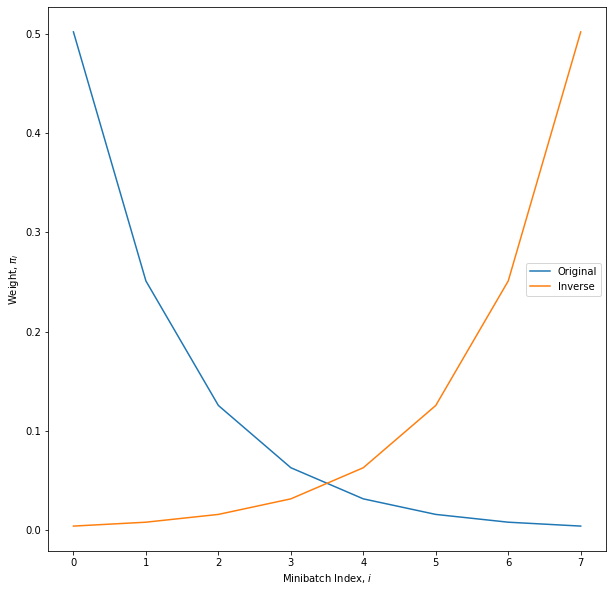

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(idx, pi, label='Original')
ax.plot(idx, pi_inv, label='Inverse')
ax.set_xlabel(r'Minibatch Index, $i$')
ax.set_ylabel(r'Weight, $\pi_i$')
ax.legend()

In [4]:
matplotlib.style.use('default')
plt.rcParams.update({'axes.titlesize': 'large', 'axes.labelsize': 'medium'})
colors_hex = {'blue': '#1F77B4', 'orange': '#FF7F0E', 'green': '#2CA02C'}
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [5]:
X_val = load_mnist(train=False, batch_size=128, shuffle=True)

/Users/maxbronckers/Downloads/BBB/env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
ModelDetails = namedtuple('ModelDetails', 'dir mclass description')

In [12]:
RICH_MODELS = {
    "bnn_rich_1200": ModelDetails("../saved_models/BBB_classification/rich_kl_reweight/1200/2022-03-26-13.11.01", ClassificationBNN, "BNN - 1200 hidden units, MoG, 300 epochs (inv KL re-weighting)"),
    "bnn_rich_800": ModelDetails("../saved_models/BBB_classification/rich_kl_reweight/400/2022-03-26-15.08.11", ClassificationBNN, "BNN - 800 hidden units, MoG, 300 epochs (inv KL re-weighting)"),
    "bnn_rich_400": ModelDetails("../saved_models/BBB_classification/rich_kl_reweight/800/2022-03-26-13.21.09", ClassificationBNN, "BNN - 400 hidden units, MoG, 300 epochs (inv KL re-weighting)"),
}

In [11]:
MODEL = "bnn_rich_1200"
MODEL_DETAILS = RICH_MODELS[MODEL]
net, params = load_model(MODEL, MODEL_DETAILS)

2022-03-29 00:48:16,622 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 00:48:16,622 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 00:48:16,633 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 00:48:16,634 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 00:48:16,635 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 00:48:16,635 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5


Parameters(name='BBB_classification', input_dim=784, output_dim=10, batch_size=128, epochs=300, hidden_units=1200, hidden_layers=3, lr=0.0001, step_size=5000, opt_choice='Adam', gamma=0.1, weight_mu_range=[-0.2, 0.2], weight_rho_range=[-5, -4], prior_params=PriorParameters(w_sigma=1.0, b_sigma=1.0, w_sigma_2=0.0024787521766663585, b_sigma_2=0.0024787521766663585, w_mixture_weight=0.5, b_mixture_weight=0.5), elbo_samples=2, inference_samples=10, regression_likelihood_noise=None, kl_reweighting_type=2, vp_variance_type=1, prior_type=1, local_reparam_trick=False, dropout=False, dropout_p=None, early_stopping=False, early_stopping_thresh=0, model_save_basedir='./saved_models', tensorboard_save_dir='./tensorboard')

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

results = {}
for num_hidden_units in [400, 800, 1200]:
    
    for MODEL in [f"bnn_rich_{num_hidden_units}", f"bnn_mog_{num_hidden_units}"]:
        if MODEL.__contains__("rich"):
            MODEL_DETAILS = RICH_MODELS[MODEL]
            net, params = load_model(MODEL, MODEL_DETAILS)
        else:
            MODEL_DETAILS = MODEL_DETAILS_DICT[MODEL]
            net, params = load_model(MODEL)
        
        description = MODEL_DETAILS.description
        weight_samples = net.weight_samples()
        comb_weight_samples = torch.hstack(weight_samples)
        sns.kdeplot(comb_weight_samples.flatten().detach().cpu().numpy(), fill=True, clip=[-0.3, 0.3], ax=ax, label=description)

        test_errors = 1 - np.load(os.path.join(MODEL_DETAILS.dir, 'eval_metric.npy'))
        test_error = test_errors[-1]
        results[MODEL] = test_error

        print(f"{MODEL:<10}: \t{round(test_error,4):>3}")

    # Formatting of plot
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right', prop={'size': 12})

    # Save the figure
    save_dir = "../plots/classification/kl_reweighting"
    plt.savefig(os.path.join(save_dir, f'{num_hidden_units}_comb_weights_plot.png'), pad_inches=0.2, bbox_inches='tight')

    # Display the plot
    plt.show()

2022-03-29 13:35:21,675 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 13:35:21,676 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 13:35:21,681 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 13:35:21,681 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 13:35:21,683 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 13:35:21,683 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5


In [ ]:
print(results)

#### Weight distribution for all Rich Models separately

2022-03-29 01:12:33,440 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:12:33,440 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:12:33,451 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:12:33,451 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:12:33,452 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:12:33,452 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5


-- bnn_rich_1200 --


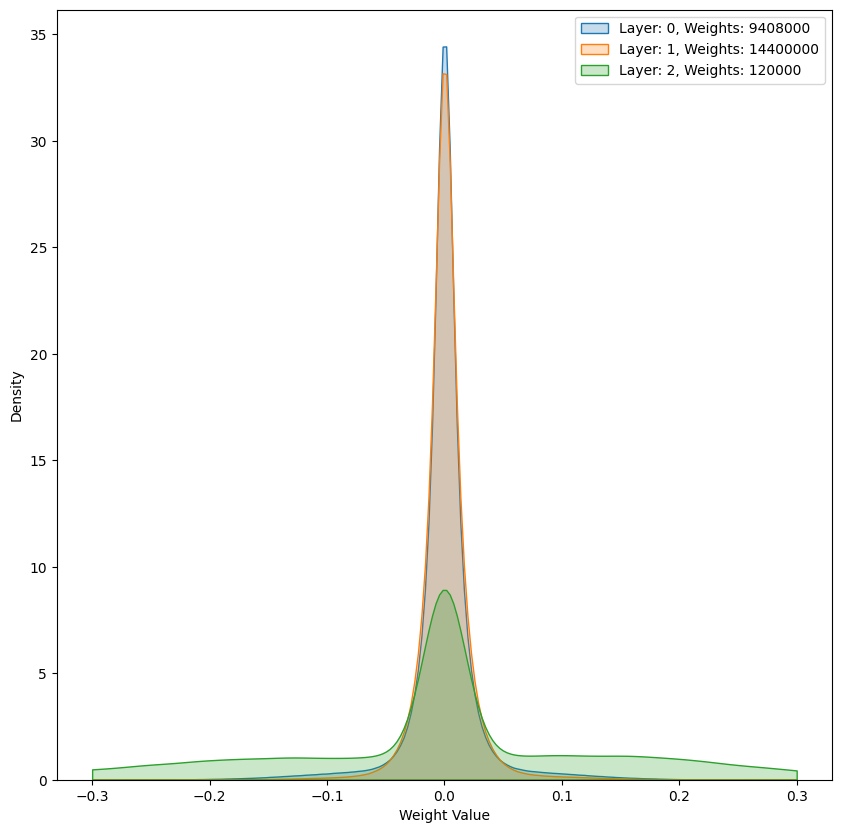

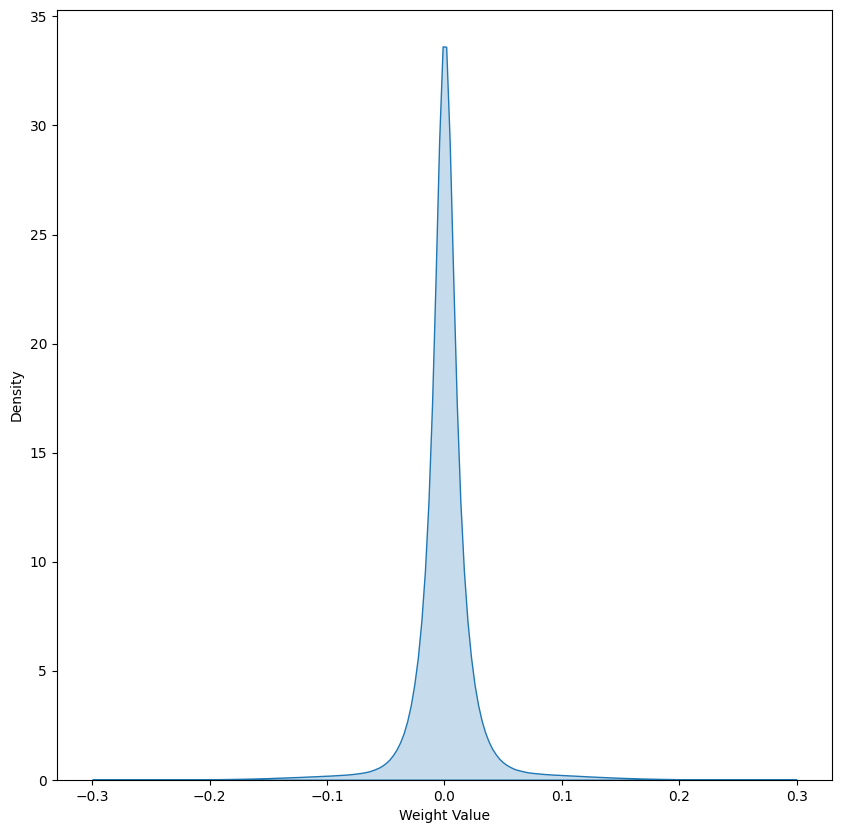

2022-03-29 01:13:05,428 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:05,429 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:05,431 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:05,431 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:05,432 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:05,432 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5


bnn_rich_1200: 	0.0148
-- bnn_rich_800 --


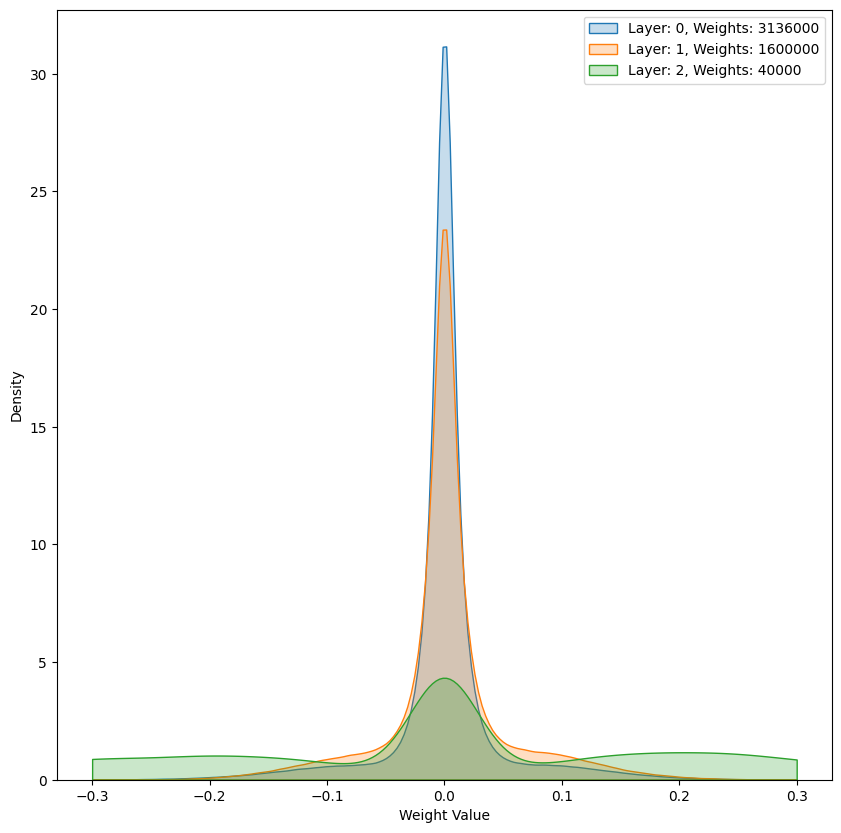

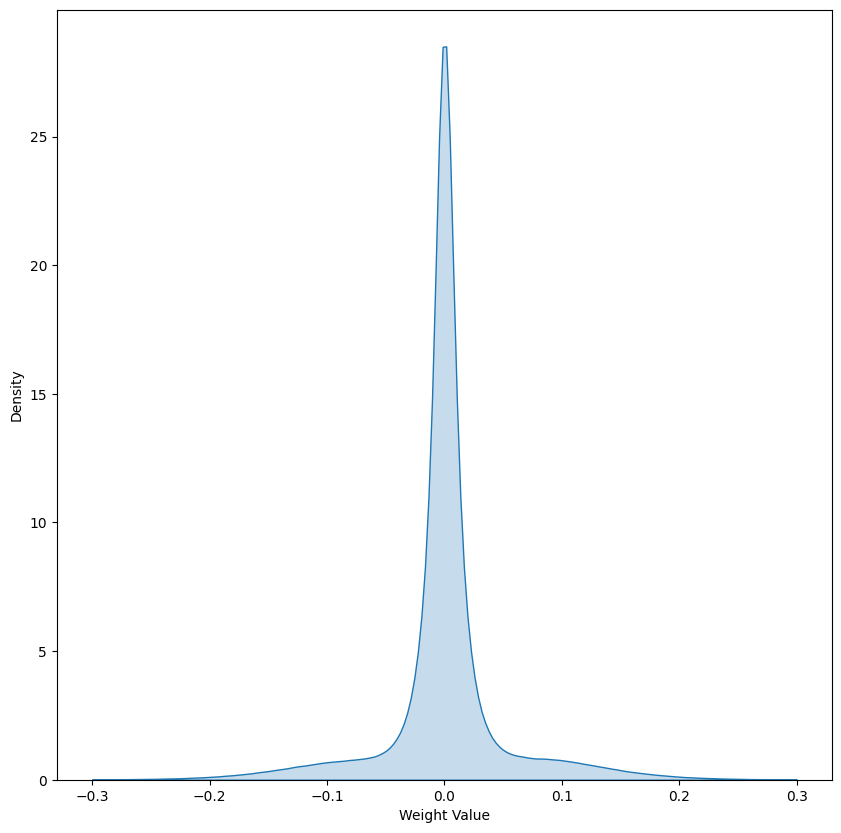

2022-03-29 01:13:12,711 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:12,712 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:12,717 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:12,717 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:12,719 - bbb.models.layers - INFO - Weights Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5
2022-03-29 01:13:12,719 - bbb.models.layers - INFO - Biases Prior: Gaussian mixture with means (0, 0), variances (1.0, 0.0024787521766663585) and weight 0.5


bnn_rich_800: 	0.0163
-- bnn_rich_400 --


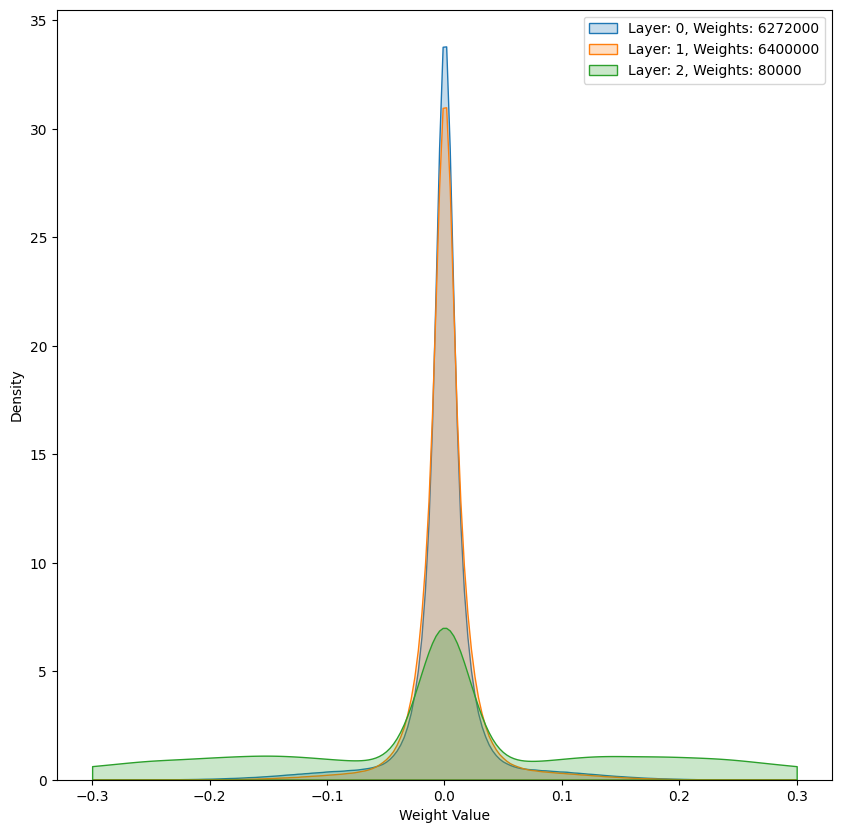

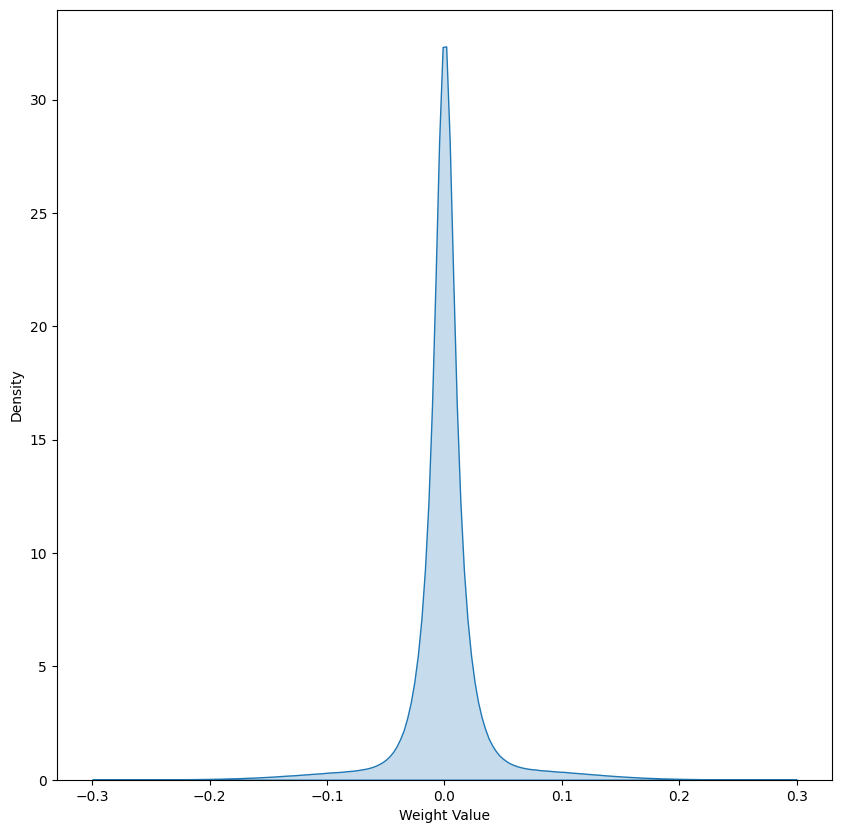

bnn_rich_400: 	0.0149


In [17]:
# results = {}

# for MODEL in RICH_MODELS.keys():
#     results[MODEL] = {}
    
for MODEL in RICH_MODELS.keys():
    print(f"-- {MODEL} --")
    MODEL_DETAILS = RICH_MODELS[MODEL]
    net, params = load_model(MODEL, MODEL_DETAILS)
    
    plot_weight_samples(net.weight_samples())

    test_errors = 1 - np.load(os.path.join(MODEL_DETAILS.dir, 'eval_metric.npy'))
        
    test_error = test_errors[-1]
        
    print(f"{MODEL:<10}: \t{round(test_error,4):>3}")

